# RQ1 Analysis (feasibility)

## Filtering out invalid models

In [5]:
import re
import pandas as pd

# Extract model names from the log file
with open('../results/RQ1/invalid_metamodels_log.txt', "r", encoding="utf-8") as f:
    log_content = f.read()

model_names_to_remove = re.findall(r"error loading metamodel:\s+(.+?)\s+with", log_content)

df = pd.read_csv("../results/RQ1/metamodels.csv")

# Filter out rows where 'model' is in the list of models to remove
filtered_df = df[~df['model'].isin(model_names_to_remove)]
cols = ['classes', 'attributes', 'refs', 'containments']
# removing metamodels with only data type elements (no structural elements)
filtered_df = filtered_df[~(df[cols] == 0).all(axis=1)]
filtered_df.to_csv("../results/RQ1/valid_metamodels.csv", index=False)

print(f"Removed {len(df) - len(filtered_df)} rows. {len(filtered_df)} Saved to 'valid_metamodels.csv'.")


Removed 329 rows. 2091 Saved to 'valid_metamodels.csv'.


C:\Users\lamp6\AppData\Local\Temp\ipykernel_24132\1395764469.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[~(df[cols] == 0).all(axis=1)]


## Plotting metamodel's data

In [6]:
import pandas as pd

df = pd.read_csv('../results/RQ1/valid_metamodels.csv')
df.info

<bound method DataFrame.info of                   model   LOC  classes  attributes  refs  containments  \
0              .skriven    47        6           8     2             0   
1          101companies    37        3           7     0             4   
2               abapobj   220       13          47     7            13   
3                 ABase    23        5           4     0             0   
4                   ABC    18        3           0     0             0   
...                 ...   ...      ...         ...   ...           ...   
2086  ZEvesProofProcess    29        4           5     0             0   
2087                Zoo    29        9           1     0             4   
2088        zvisclasses    36        5          10     1             3   
2089                 _0  3188       86         151     0           104   
2090             µOCCAM   177       57          26     0            44   

      maxDIT  maxHagg  
0          3        1  
1          1        3  
2      

In [7]:
# Compute total
df['total'] = df[['classes', 'attributes', 'refs', 'containments']].sum(axis=1)

# Columns to summarize
cols = ['classes', 'attributes', 'refs', 'containments','maxDIT','maxHagg', 'total']

# Compute statistics
summary = df[cols].agg(['min', 'median', 'mean', 'max', 'std'])

summary = summary.T

# Generate LaTeX table with bold row labels
latex_table = r"""\begin{table}[t]
\centering
\caption{Size of the metamodels loaded for RQ1}
\label{tab:metamodelstats}
\footnotesize
\begin{tabular}{p{4.5em}rrcrr}
\toprule
\textbf{Count} & \textbf{Min} & \textbf{Max} & \textbf{Median} & \textbf{Mean} & \textbf{St. dev} \\
\midrule
"""

for idx, row in summary.iterrows():
    latex_table += f"\\textbf{{{idx}}} & {int(row['min'])} & {int(row['max'])} & {int(row['median'])} & {row['mean']:.2f} & {row['std']:.2f} \\\\\n"

latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

print(latex_table)


\begin{table}[t]
\centering
\caption{Size of the metamodels loaded for RQ1}
\label{tab:metamodelstats}
\footnotesize
\begin{tabular}{p{4.5em}rrcrr}
\toprule
\textbf{Count} & \textbf{Min} & \textbf{Max} & \textbf{Median} & \textbf{Mean} & \textbf{St. dev} \\
\midrule
\textbf{classes} & 1 & 945 & 9 & 25.49 & 64.57 \\
\textbf{attributes} & 0 & 7933 & 8 & 31.35 & 203.80 \\
\textbf{refs} & 0 & 1262 & 3 & 12.92 & 54.11 \\
\textbf{containments} & 0 & 1291 & 4 & 16.00 & 49.47 \\
\textbf{maxDIT} & 1 & 23 & 2 & 2.74 & 1.92 \\
\textbf{maxHagg} & 1 & 30 & 3 & 3.14 & 2.07 \\
\textbf{total} & 1 & 8410 & 30 & 85.76 & 288.59 \\
\bottomrule
\end{tabular}
\end{table}



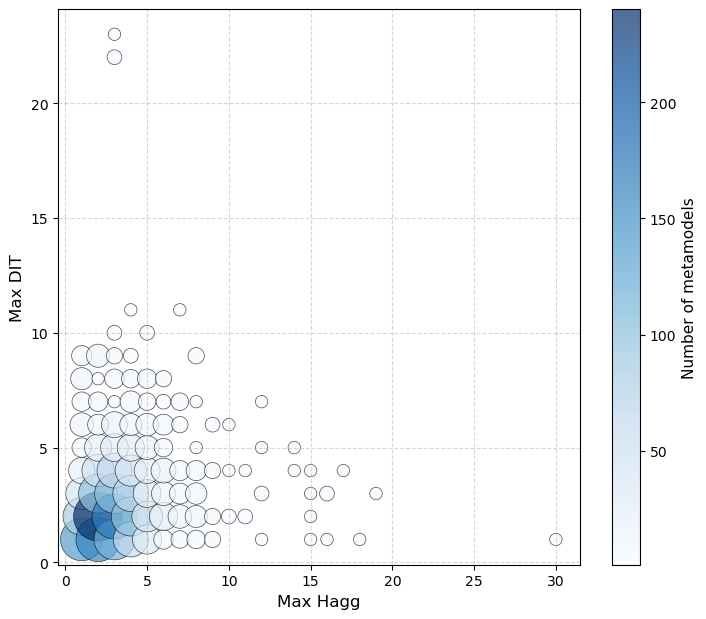

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
 
df = pd.read_csv("../results/RQ1/valid_metamodels.csv") 
# group by coordinates to count duplicates
grouped = df.groupby(["maxHagg", "maxDIT"]).size().reset_index(name="count") 
sizes = np.sqrt(grouped["count"]) * 80  
 
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    grouped["maxHagg"],
    grouped["maxDIT"],
    s=sizes,
    c=grouped["count"],          
    cmap="Blues",             
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5
)
 
plt.xlabel("Max Hagg", fontsize=12)
plt.ylabel("Max DIT", fontsize=12) 

 
cbar = plt.colorbar(scatter)
cbar.set_label("Number of metamodels", fontsize=11) 
 
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout(pad=0)
plt.savefig("img/RQ1max.pdf", format='pdf', bbox_inches='tight') 
plt.show()


C:\Users\lamp6\AppData\Local\Temp\ipykernel_24132\1101009373.py:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


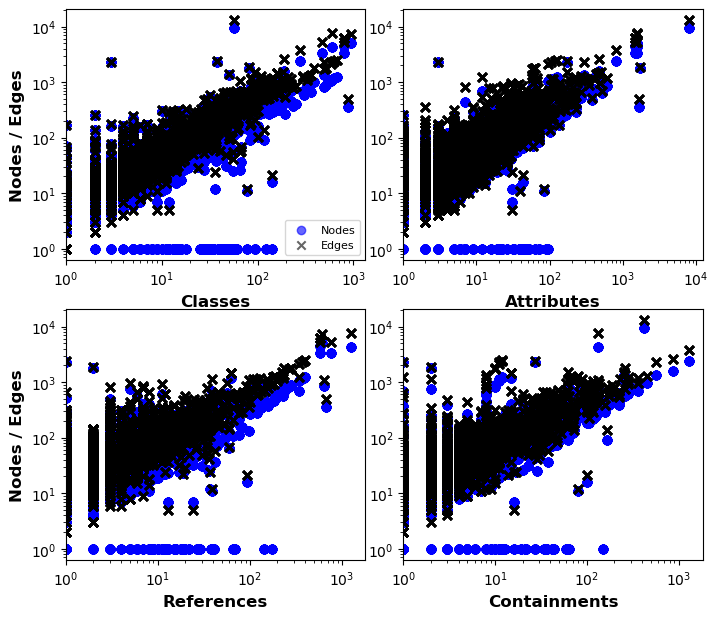

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

valid_df = pd.read_csv('../results/RQ1/valid_metamodels.csv')
run_files = glob.glob('../results/RQ2/metamodels_run_*.csv')
combined_df = pd.concat([pd.read_csv(f) for f in run_files], ignore_index=True)
combined_df = pd.merge(combined_df, valid_df, on='model', suffixes=('_run', '_model'))

props = ['classes', 'attributes', 'refs', 'containments']
axis_labels = {
    'classes': 'Classes',
    'attributes': 'Attributes',
    'refs': 'References',      
    'containments': 'Containments',  
}
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
axes = axes.flatten()

for idx, prop in enumerate(props):
    ax = axes[idx]
    ax.scatter(combined_df[prop], combined_df['nodes'], color='blue', alpha=0.6, marker='o', label='Nodes', rasterized=True)
    ax.scatter(combined_df[prop], combined_df['edges'], color='black', alpha=0.6, marker='x', label='Edges', rasterized=True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(axis_labels[prop], fontsize=12, fontweight='bold')
    if idx % 2 == 0:
        ax.set_ylabel('Nodes / Edges', fontsize=12, fontweight='bold')
    ax.set_xlim(left=1)
    ax.set_ylim(bottom=0)
    # Show legend only on the first subplot
    if idx == 0:
        ax.legend(fontsize=8, loc='lower right')

plt.tight_layout(pad=0) 
plt.savefig("img/RQ1nodesedges.pdf", format='pdf', bbox_inches='tight')
plt.show()
